# P5 Starter - Time Series Analysis 

### Statistical Modeling to Deep Learning

##  Imports & Sanity Check (Do NOT Change)

In [1]:
import numpy as np 
import pandas as pd 
import os
from tqdm.notebook import tqdm
import statsmodels.api as sm # PACF, ACF
from typing import Tuple, List

# Viz:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/helper/helper.py
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/oil.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/stores.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/train.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/test.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/transactions.csv


In [2]:
import importlib.util
import sys

file_path = '/kaggle/input/helper/helper.py'  # full path to the file

spec = importlib.util.spec_from_file_location("helper", file_path)
helper = importlib.util.module_from_spec(spec)
sys.modules["helper"] = helper
spec.loader.exec_module(helper)

## Helper Utilities. Read the Function names at least so that you are not re-writing code

* **make_submission**: Helps you convert your predictions to competition submission ready files.
* **rmsle**: Implementation of the metric used to evaluate your score on the leaderboard.
* **lgbm_rmsle**: Definition that can be used to do train-val type training while printing metric scores.
* **data import**: Imports the necessary files into the notebook
* **preprocess_holidays**: Performs some necessary cleaning on the holiday dataset
* **preprocess_test_train**: Performs some necessary cleaning on the test and train dataset

## Load the data (Do NOT Change)

In [3]:
#########################
# DO NOT CHANGE
#########################
train, test, stores, transactions, oil, holidays = helper.data_import()
holidays, regional, national, local, events, work_day, _, _, _ = helper.preprocess_holidays(holidays)

## Section 1: EDA & Feature Engineering

### Q1 Left join transaction to train and then print the Spearman Correlation between Total Sales and Transactions.

In [4]:
#q1
train['source'] = 'train'
test['source'] = 'test'
test['sales'] = np.nan
test['sales'] = test['sales'].astype('float32')

merged_df = pd.concat([train, test], axis=0).reset_index(drop=True)

merged_df = pd.merge(
    merged_df,
    transactions,
    on=['date', 'store_nbr'],
    how='left'
)

train_with_transactions = merged_df[merged_df['source'] == 'train']

grouped_by_date = train_with_transactions.groupby(['date', 'store_nbr']).agg({
    'sales': 'sum',
    'transactions': 'mean'
}).reset_index()

spearman_corr = grouped_by_date['sales'].corr(grouped_by_date['transactions'], method='spearman')

print(f"Spearman Correlation between Total Sales and Transactions: {spearman_corr}")

Spearman Correlation between Total Sales and Transactions: 0.8177779231888965


### Q2 Plot an 'ordinary least squares' trendline between transactions and sales to verify the spearman correlation value in Q1. [0.1 Points]

In [5]:
#q2
fig_q2 = px.scatter(
    grouped_by_date,
    x='transactions',
    y='sales',
    trendline='ols',
    trendline_color_override="red",
    title='OLS Trendline Between Transactions and Total Sales',
    labels={'transactions': 'Average Transactions', 'sales': 'Total Sales'}
)

fig_q2.write_html("q2.html")

### Q3 Plot these line charts in the notebook:

A) Transactions vs Date (all stores color coded in the same plot) 

B) Average monthly transactions

 C) Average Transactions on the days of the wee)


In [6]:
#q3 - Plot A
fig_q3a = px.line(
    transactions,
    x='date',
    y='transactions',
    color='store_nbr',
    title='Transactions Over Time by Store',
    labels={'date': 'Date', 'transactions': 'Transactions'}
)

fig_q3a.update_xaxes(tickformat='%Y') 

fig_q3a.write_html('q3a.html')

In [7]:
#q3 - Plot B
transactions['month'] = transactions['date'].dt.month_name()
monthly_avg = transactions.groupby('month')['transactions'].mean().reset_index()

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_avg['month'] = pd.Categorical(monthly_avg['month'], categories=month_order, ordered=True)
monthly_avg = monthly_avg.sort_values('month')


fig_q3b = px.line(
    monthly_avg,
    x='month',
    y='transactions',
    title='Average Monthly Transactions',
    labels={'month': 'Month', 'transactions': 'Average Transactions'}
)

fig_q3b.update_xaxes(tickformat='%b')

fig_q3b.write_html("q3b.html")

In [8]:
#q3 - Plot C
transactions['day_of_week'] = transactions['date'].dt.day_name()
weekday_avg = transactions.groupby('day_of_week')['transactions'].mean().reset_index()


weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_avg['day_of_week'] = pd.Categorical(weekday_avg['day_of_week'], categories=weekday_order, ordered=True)
weekday_avg = weekday_avg.sort_values('day_of_week')

fig_q3c = px.line(
    weekday_avg,
    x='day_of_week',
    y='transactions',
    title='Average Transactions by Day of the Week',
    labels={'day_of_week': 'Day of Week', 'transactions': 'Average Transactions'}
)

fig_q3c.write_html("q3c.html")

### Q4 Use pandas' in-build (linear) interpolation to impute the missing oil values then overlay the imputed feature over the original.

Your new feature column should be called: `dcoilwtico_interpolated`

In [9]:
#q4
# Interpolate. 
oil['dcoilwtico_interpolated'] = oil['dcoilwtico'].interpolate(method='linear')

# Plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=oil['date'],
    y=oil['dcoilwtico'],
    mode='lines',
    name='Original',
    line=dict(color='darkblue', width=2),
    opacity=0.6
))

fig.add_trace(go.Scatter(
    x=oil['date'],
    y=oil['dcoilwtico_interpolated'],
    mode='lines',
    name='Interpolated',
    line=dict(color='red', width=2, dash='dash')
))

fig.update_layout(
    title='Oil Prices: Original vs Interpolated',
    xaxis_title='Date',
    yaxis_title='Oil Price',
    legend_title='Legend',
    template='plotly_white'
)

fig.write_html("q4.html")

### Q5 Again, left join oil on the dataframe above and report the spearman correlation between oil and sales and oil and transactions

In [10]:
#q5
# Find correlation with sales & transactions
merged_df = pd.merge(
    merged_df,
    oil[['date', 'dcoilwtico_interpolated']],
    on='date',
    how='left'
)

train_with_oil_and_transactions = merged_df[merged_df['source'] == 'train']


grouped_by_date_with_oil = train_with_oil_and_transactions.groupby(['date', 'store_nbr']).agg({
    'sales': 'sum',
    'transactions': 'mean',
    'dcoilwtico_interpolated': 'mean'
}).reset_index()

spearman_corr_sales = grouped_by_date_with_oil['sales'].corr(grouped_by_date_with_oil['dcoilwtico_interpolated'], method='spearman')
spearman_corr_transactions = grouped_by_date_with_oil['transactions'].corr(grouped_by_date_with_oil['dcoilwtico_interpolated'], method='spearman')


print(f"Correlation Between Oil and Sales: {spearman_corr_sales}")
print(f"Correlation Between Oil and Transactions: {spearman_corr_transactions}")

Correlation Between Oil and Sales: -0.3172626697554721
Correlation Between Oil and Transactions: 0.03799680292119282


### Q6 Report the top-3 highest negative correlations between oil and sales of a particular product family. Now think whether oil should be discarded as a feature?

In [11]:
#q6
# Calculate all correlations
train_with_oil = pd.merge(
    train,
    oil[['date', 'dcoilwtico_interpolated']],
    on='date',
    how='left'
)

correlations = train_with_oil.groupby('family').apply(
    lambda group: group[['dcoilwtico_interpolated', 'sales']].corr(method='spearman').loc['dcoilwtico_interpolated', 'sales']
).sort_values()

# Report the top 3
top_3_negative_correlations = correlations.head(3)
print(f"Top 3 families with highest negative correlation with oil prices: {top_3_negative_correlations}")

Top 3 families with highest negative correlation with oil prices: family
HOME AND KITCHEN II   -0.652518
HOME AND KITCHEN I    -0.593218
HOME CARE             -0.541245
dtype: float64


/tmp/ipykernel_12848/1546195165.py:10: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



No, oil should not be discarded as a feature. As we can see from the top 3 negative correlations, certain product families show strong negative correlations to oil prices. This indicates that oil prices can significantly impact the sales of non-essential and discretionary products and suggests that oil prices can be a valuable predictor in modeling sales behavior for certain segments. Moreover, considering that the dataset pertains to Ecuador, an oil-dependent country, including oil as a feature aligns well with domain knowledge.

However, the impact of oil prices is not uniform across all product families. Sales of essential goods show weak or near-zero correlation with oil prices. This aligns with our intuition that consumers continue purchasing necessities regardless of economic shifts.

Therefore, oil should be retained as a feature, but applied cautiously.



### Q7. Implement the One hot encode function 

You just have to finish the one-hot encoder function definition for this one.

In [12]:
#q7
def one_hot_encoder(df, nan_as_category=True) -> Tuple[pd.DataFrame, List[str]]:
    # One hot encoding (pandas can do it on 1 line!) 
    df_encoded = pd.get_dummies(
    df,
    columns=df.select_dtypes(include=['object', 'category']).columns,
    dummy_na=nan_as_category)
    # Replace " " with "_" in column names.
    df_encoded.columns = df_encoded.columns.str.replace(' ', '_')
    # Store the new columns in a list
    new_columns = list(df_encoded.columns)
    # Return the new dataframe and all the columns (as a list)
    return df_encoded, new_columns

In [13]:
#########################
# DO NOT CHANGE. 
# NOTE: Run this after you have implemented the one_hot_encoder function above.
#########################

train, test = helper.preprocess_test_train(merged_df, one_hot_encoder, stores)

train_cols = set(train.columns) - {'sales'}
test_cols = set(test.columns)

common_cols = train_cols & test_cols

train = train[list(common_cols) + ['sales']]
test = test[list(common_cols)]

## Section 2

### Q8. EMA

Forecast window should be >=15 days since the test set is 15 days. **For this question use 16 as the forecast window**

In [14]:
# Train EMAs for each family per store (pandas has an inbuilt ema function!)
train_data = merged_df[merged_df['source'] == 'train'].copy()

ema_lookup = (
    train_data.sort_values('date')
    .groupby(['store_nbr', 'family'])['sales']
    .apply(lambda x: x.ewm(span=16, adjust=False).mean().iloc[-1])
    .reset_index()
    .rename(columns={'sales': 'ema_prediction'})
)

test_data = merged_df[merged_df['source'] == 'test'].copy()

test_with_ema = pd.merge(
    test_data,
    ema_lookup,
    on=['store_nbr', 'family'],
    how='left'
)

ema_forecast = test_with_ema['ema_prediction'].fillna(0)

In [15]:
# Make the predictions

# Use the make_submission utility function provided to save a submission CSV. 

# Submit to competition and note your RMSLE score somewhere for this model type.

# NOTE - 1: You still need to go on the right panel and click submit 
# (make_submission will NOT submit to competition -> It just makes a submission ready file)
# NOTE - 2: Ensure that you are not overwriting your submission.csv file in subsequent cells.

# Use the make_submission utility function provided to save a submission CSV.

helper.make_submission(ema_forecast, file_name="EMA_results.csv")
ema_submission = pd.read_csv('EMA_results.csv')
ema_submission.to_csv('submission.csv', index=False)

### Q9. PACF and ACF

Use lib sm 

(statsmodel.api is already imported as sm)

ACF stands for Auto Correlation Function.
It measures the correlation of a time series with its own past values.
ACF at lag k tells us how correlated the series is with itself k time series units ago.

PACF stands for Partial Auto Correlation Function.
It measures the direct correlation between a time series and its lag k while removing the influence of any intermediate lags (1 to k-1). 

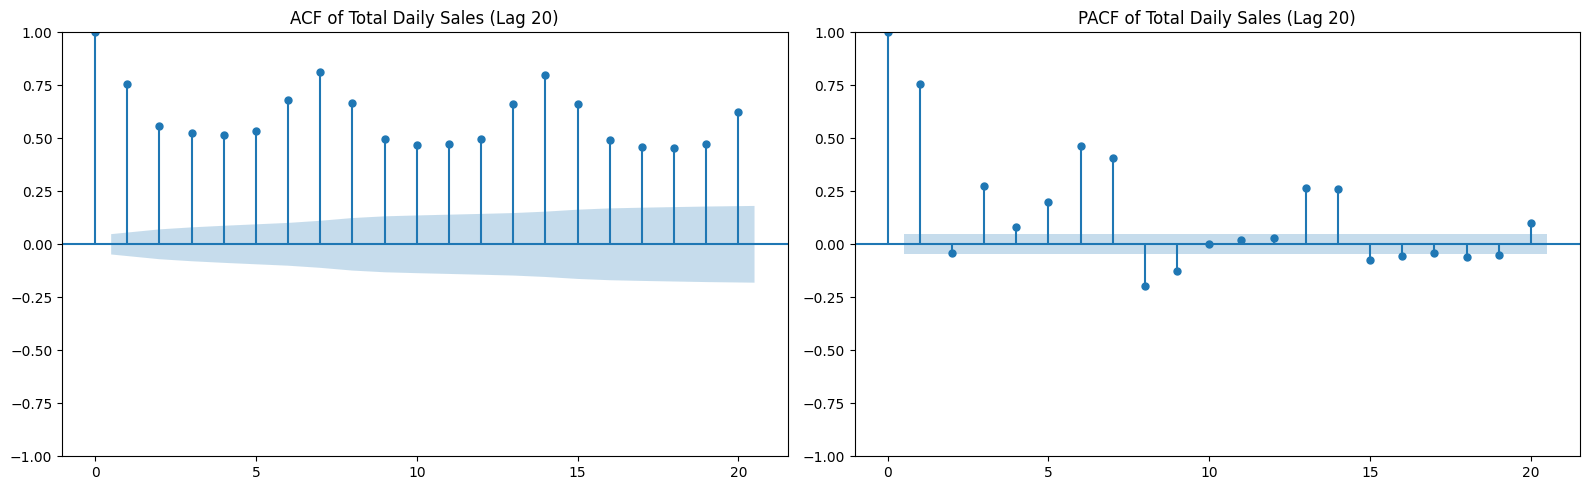

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

train_daily_sales = train[train['sales'].notna()].groupby('date')['sales'].sum()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(train_daily_sales, ax=axes[0], lags=20)
axes[0].set_title('ACF of Total Daily Sales (Lag 20)')

plot_pacf(train_daily_sales, ax=axes[1], lags=20)
axes[1].set_title('PACF of Total Daily Sales (Lag 20)')

plt.tight_layout()
plt.savefig("q9.png")
plt.show()

ACF Plot Interpretation:
The plot shows strong positive autocorrelation across all lags upto lag 20. The autocorrelation also decays very slowly and does not cut off quickly. Spikes in the plot around lags 7, 14, 21 indicate a weekly seasonality.

PACF Plot Interpretation:
The plot shows a high value at lag 1 followed by moderate spikes up to around lag 7 after which the values tail off. This indicates that the current day's sales are directly influenced by the past 7 days further implying a weekly seasonality.

### Q10. ADF Test -> ARIMA

#### Differencing technique
This process is meant to transform the time series data to stationary, as ARIMA model only works with stationary time series data.

In [17]:
# 1. Compute and store the diff series
# 2. Drop NA or any other erroneous values.
diff_series = train_daily_sales.diff().dropna()

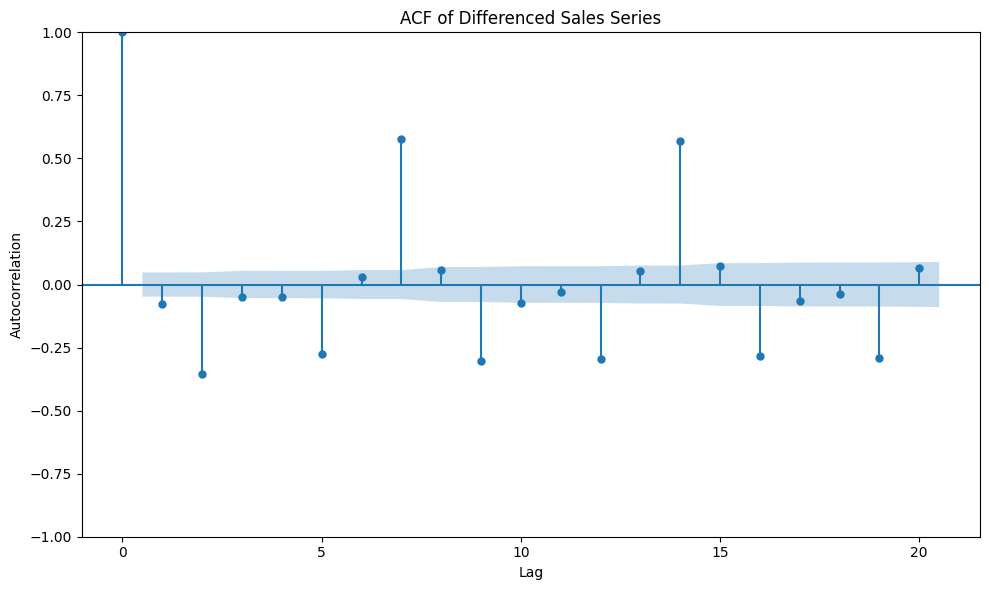

In [18]:

# Plot the ACF
fig, ax = plt.subplots(figsize=(10, 6))

##########
# Your plot code goes here:
##########
plot_acf(diff_series, ax=ax, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of Differenced Sales Series')
plt.tight_layout()
plt.savefig("q10.png")
plt.show()

##########

### Augmented Dickey-Fuller (ADF) test

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary or non-stationary. Stationarity is an important assumption in many time series analysis models.

The ADF test evaluates the null hypothesis that the time series has a unit root, indicating non-stationarity. The alternative hypothesis is that the time series is stationary.

When performing the ADF test, we obtain the ADF statistic and the p-value. The ADF statistic is a negative number and the more negative it is, the stronger the evidence against the null hypothesis. The p-value represents the probability of observing the ADF statistic or a more extreme value if the null hypothesis were true. A low p-value (below a chosen significance level, typically 0.05) indicates strong evidence against the null hypothesis and suggests that the time series is stationary.

In [19]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [20]:
# 1. Perform the ADF test
adf_result = adfuller(diff_series)
# 2. Extract the test statistics and p-value
adf_statistic, p_value = adf_result[0:2]
# 3. Print these values
print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")

ADF Statistic: -11.553711234361751
p-value: 3.3987504192949185e-21


The ADF statistic is (around) -11.4. This statistic is a negative value and is more negative than the critical values at common significance levels. This suggests strong evidence against the null hypothesis of a unit root, indicating that the time series is stationary.

The p-values (around)  i6.76e-2121, which is a very small value close to zero. Typically, if the p-value is below a chosen significance level (e.g., 0.05), it indicates strong evidence to reject the null hypothesis. In your case, the extremely small p-value suggests strong evidence against the presence of a unit root and supports the stationarity of the time series.

**TODO** Choose the right p, q and d values for your ARIMA model

In [21]:
# Replace with appropriate p,d,q values for ARIMA
p_arima = 7 # PACF spikes till lag 7

d_arima = 1 # d=1 makes the series stationary as per ADF test

q_arima = 2 # Based on ACF plot gradual decay

In [22]:
# 1. Get sales series as training data (np array with appropriate dtype)

# 2. Using statsmodel.tsa lib. Initialize an ARIMA model with the p,d,q params you defined. 
arima_model = ARIMA(train_daily_sales, order=(p_arima, d_arima, q_arima))
# 3. Fit the model
arima_model_fit = arima_model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [23]:
# Print the post model fitting summary
print("ARIMA model summary: ")
print(arima_model_fit.summary())

ARIMA model summary: 
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1669
Model:                 ARIMA(7, 1, 2)   Log Likelihood              -21771.175
Date:                Fri, 18 Apr 2025   AIC                          43562.350
Time:                        17:50:13   BIC                          43616.544
Sample:                             0   HQIC                         43582.432
                               - 1669                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1188      0.083     -1.424      0.154      -0.282       0.045
ar.L2         -0.5142      0.078     -6.598      0.000      -0.667      -0.361
ar.L3         -0.2741      0.0

The MA and AR coefficients are statistically significant with most of them having p-values less than 0.05

In [24]:
# Make predictions & submit to competition using your best model
forecast = arima_model_fit.get_forecast(steps=15)
forecast_values = forecast.predicted_mean
forecast_df = pd.DataFrame({
    'date': pd.date_range(start=train_daily_sales.index[-1] + pd.Timedelta(days=1), periods=15),
    'sales': forecast_values
})
forecast_df.to_csv("ARIMA_results.csv")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



## Section 3

### Q11 Define a validation set. What will be the most appropriate time period for this validation set?

In the dataset given to us:  
Train dataset starts from: 2013-01-01 to 2017-07-31  
Test dataset starts from:  2017-08-01 to 2017-08-15 (2 weeks)  

Now, we want the validation dataset to be immediately preceding the test dataset and to be of the same duration as the test dataset to mirror the test dataset structure.   

Therefore, the ideal time period for the validation set will be:  
2017-07-18 to 2017-07-31 (previous 2 weeks).  


In [25]:
# Get the val set:
first_date = test['date'].min()
last_date = test['date'].max()

validation_duration = last_date - first_date
val_start_date = first_date - validation_duration
val_end_date = first_date - pd.Timedelta(seconds=1)

val = train[(train['date'] >= val_start_date) & (train['date'] <= val_end_date)]

train = train[~train.index.isin(val.index)]

### Q12. LightGBM

In [26]:
import lightgbm as lgb

In [27]:
# Process your data to the appropriate dtypes, vars, etc.
target_col = 'sales'
exclude_cols = ['id', 'date', 'sales']
features = [col for col in train.columns if col not in exclude_cols]

X_train = train[features]
Y_train = train[target_col]

X_val = val[features]
Y_val = val[target_col]

X_test = test[features]

In [28]:
# Use the lgb.Dataset method to intialize your dataset iterables.

# 1. Make one for the train set:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=features)
# 2. Make another for the val set you defined in Q13:
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=features)

In [29]:
# Fill the dict with appropriate params:
lgb_params = {'num_leaves': 30,
              'learning_rate': 0.05,
              'feature_fraction': 0.8,
              'max_depth': 6,
              'num_boost_round': 5000,
              'early_stopping_rounds': 100,
              'nthread': -1}

In [30]:
# Complete the model initialization/train params)
model = lgb.train(
    lgb_params,
    lgbtrain,
    valid_sets=[lgbtrain, lgbval],
    feval=helper.lgbm_rmsle
)

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.052635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1116
[LightGBM] [Info] Number of data points in the train set: 2951256, number of used features: 168
[LightGBM] [Info] Start training from score 355.926499
Training until validation scores don't improve for 100 rounds


/kaggle/input/helper/helper.py:44: RuntimeWarning:

invalid value encountered in log1p



Early stopping, best iteration is:
[88]	training's l2: 149564	training's RMSLE: nan	valid_1's l2: 109181	valid_1's RMSLE: 1.83823


In [31]:
# 1. Predict the sales value on your val set using the best_iteration recorded by the LGBM
Y_val_preds = model.predict(X_val, num_iteration=model.best_iteration)
Y_val_preds = np.clip(Y_val_preds, 0, None)
# 2. Compute and print the RMSLE on this val set.
val_score = helper.rmsle(Y_val_preds, Y_val)
print(f"Validation RMSLE: {val_score}")

Validation RMSLE: 1.8337347646475084


In [32]:
# 1. Pre-process your test set to appropriate format.
# 2. Predict -> Save using make_submission -> Submit to competition
Y_test_preds = model.predict(X_test, num_iteration=model.best_iteration)
Y_test_preds = np.clip(Y_test_preds, 0, None)
# 3. Note your RMSLE for LGBM
helper.make_submission(Y_test_preds, file_name="LightGBM_results.csv")
gbm_submission = pd.read_csv('LightGBM_results.csv')
gbm_submission.to_csv('submission.csv', index=False)
print(f"Submission RMSLE for LightGBM: 1.81456")

Submission RMSLE for LightGBM: 1.81456


### Q13. CatBoost

In [33]:
from catboost import Pool, CatBoostRegressor

In [34]:
# Fill out missing params for catboost appropriately here:
catboost_params = {
    'iterations': 1000,           # Number of boosting rounds
    'learning_rate': 0.05,        # Learning rate for gradient boosting
    'depth': 6,                   # Depth of each tree
    'loss_function': 'RMSE',      # Loss function (Root Mean Squared Error for regression)
    'eval_metric': 'RMSE',        # Evaluation metric
    'random_seed': 42,            # Ensures reproducibility
    'early_stopping_rounds': 100,  # Stops training if no improvement after 50 rounds
    'verbose': 100                # Prints training progress every 100 rounds
}

In [35]:
# 1. Define the model
train_pool = Pool(X_train, Y_train)
val_pool = Pool(X_val, Y_val)

model = CatBoostRegressor(**catboost_params)
# 2. Fit
model.fit(train_pool, eval_set=val_pool)
Y_val_preds = model.predict(X_val)
Y_val_preds = np.clip(Y_val_preds, 0, None)
val_score = helper.rmsle(Y_val_preds, Y_val)
print(f"Validation RMSLE: {val_score}")

0:	learn: 1059.4474795	test: 1239.5363332	best: 1239.5363332 (0)	total: 432ms	remaining: 7m 11s
100:	learn: 429.9049664	test: 375.1627276	best: 375.1627276 (100)	total: 21.9s	remaining: 3m 15s
200:	learn: 394.1894587	test: 325.5704832	best: 325.5704832 (200)	total: 43.1s	remaining: 2m 51s
300:	learn: 376.1456190	test: 300.3102242	best: 300.3102242 (300)	total: 1m 3s	remaining: 2m 27s
400:	learn: 364.3469443	test: 287.2073382	best: 287.2073382 (400)	total: 1m 24s	remaining: 2m 6s
500:	learn: 355.7382864	test: 277.8945411	best: 277.8945411 (500)	total: 1m 46s	remaining: 1m 45s
600:	learn: 348.6513032	test: 270.4713081	best: 270.4713081 (600)	total: 2m 14s	remaining: 1m 28s
700:	learn: 343.2201542	test: 265.1085067	best: 265.0618383 (698)	total: 2m 35s	remaining: 1m 6s
800:	learn: 338.6499462	test: 260.0196461	best: 260.0168804 (799)	total: 2m 56s	remaining: 43.9s
900:	learn: 334.2232632	test: 256.3384744	best: 256.3384744 (900)	total: 3m 17s	remaining: 21.7s
999:	learn: 330.1632665	test:

In [36]:
# 3. Preprocess your test data appropriately
# 4. Make Predictions
Y_test_preds = model.predict(X_test)
Y_test_preds = np.clip(Y_test_preds, 0, None)

In [37]:
# 5. Use make_submission -> Submit to competition
helper.make_submission(Y_test_preds, file_name="CatBoost_results.csv")
cb_submission = pd.read_csv('CatBoost_results.csv')
cb_submission.to_csv('submission.csv', index=False)
# 6. Note your RMSLE for this model
print(f"Submission RMSLE for CatBoost: 1.34520")

Submission RMSLE for CatBoost: 1.34520


### Q14. XGBoost

In [38]:
import xgboost as xgb
from xgboost import XGBRegressor

In [39]:
# 1. Initialize model with random state = 42 to be consistent with CatBoost
dtrain = xgb.DMatrix(X_train, label=Y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=Y_val, enable_categorical=True)
dtest = xgb.DMatrix(X_test, enable_categorical=True)

xgb_params = {
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 1.0,
    'alpha': 0.0,
    'verbosity': 1,
    'seed': 42
}

evals = [(dtrain, 'train'), (dval, 'val')]

# 2. Fit
model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=100,
    evals=evals,
    verbose_eval=100
)

Y_val_preds = model.predict(dval)
Y_val_preds = np.clip(Y_val_preds, 0, None)
val_score = helper.rmsle(Y_val_preds, Y_val)
print(f"Validation RMSLE: {val_score}")

[0]	train-rmse:1055.36917	val-rmse:1240.56695
[100]	train-rmse:357.37903	val-rmse:298.72826
[200]	train-rmse:335.04568	val-rmse:271.21242
[300]	train-rmse:325.35482	val-rmse:260.93489
[400]	train-rmse:318.15382	val-rmse:253.60260
[500]	train-rmse:311.73319	val-rmse:246.81859
[600]	train-rmse:306.74068	val-rmse:241.80147
[700]	train-rmse:302.15380	val-rmse:237.42603
[800]	train-rmse:298.57044	val-rmse:234.18360
[900]	train-rmse:295.24545	val-rmse:231.27549
[999]	train-rmse:292.27119	val-rmse:229.52989
Validation RMSLE: 1.1835602521896362


In [40]:
# 3. Make Predictions.
Y_test_preds = model.predict(dtest)
Y_test_preds = np.clip(Y_test_preds, 0, None)

In [41]:
# 4. make_submission -> Submit to competition 
helper.make_submission(Y_test_preds, file_name="XGBoost_results.csv")
xgb_submission = pd.read_csv('XGBoost_results.csv')
xgb_submission.to_csv('submission.csv', index=False)
# 5. Note your RMSLE 
print(f"Submission RMSLE for XGBoost: 1.18963")

Submission RMSLE for XGBoost: 1.18963


### Q15. Optuna for automatic hyperparameter optimization

In [42]:
import optuna
import time

In [43]:
def objective_lgb(trial):
    # 1. Define the parameter search space
    params = {
        'num_boost_round': 5000,
        'early_stopping_rounds': 100,
        'nthread': -1,
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.1),
        'num_leaves': trial.suggest_int("num_leaves", 20, 64),
        'max_depth': trial.suggest_int("max_depth", 4, 12),
        'feature_fraction': trial.suggest_float("feature_fraction", 0.6, 1.0),
        'seed': 42
    }
    
    # 2. Create datasets (train, val) for LightGBM
    lgbtrain = lgb.Dataset(X_train, label=Y_train, feature_name=features)
    lgbval = lgb.Dataset(X_val, label=Y_val, reference=lgbtrain, feature_name=features)

    # 3. Train the model
    model = lgb.train(
        params,
        lgbtrain,
        valid_sets=[lgbtrain, lgbval],
        feval=helper.lgbm_rmsle
    )

    # 4. Evaluate on the validation set
    Y_val_preds = model.predict(X_val, num_iteration=model.best_iteration)
    Y_val_preds = np.clip(Y_val_preds, 0, None)
    
    # 5. Return the metric score
    score = helper.rmsle(Y_val_preds, Y_val)
    return score

# Create Optuna study to minimize the objective function

start = time.time()
# 1. Create the optuna study and specify appropriate direction
start = time.time()
study = optuna.create_study(direction='minimize')
# 2. Optimize (pay attention to recommended trials; 50 takes too long)
study.optimize(objective_lgb, n_trials=10)
# 3. Get the best parameters
best_params = study.best_params
best_score = study.best_value
# 4. Print them.
print("Best parameters:", best_params)
print("Best RMSLE Score:", best_score)

print("Took:", time.time() - start, "seconds")

[I 2025-04-18 18:03:02,176] A new study created in memory with name: no-name-4a52d5e3-0dae-4af5-a021-12b22bcf2047
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.170128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 2951256, number of used features: 168
[LightGBM] [Info] Start training from score 355.926499
Training until validation scores don't improve for 100 rounds


/kaggle/input/helper/helper.py:44: RuntimeWarning:

invalid value encountered in log1p

[I 2025-04-18 18:03:58,158] Trial 0 finished with value: 1.5672041449280467 and parameters: {'learning_rate': 0.04477219640489942, 'num_leaves': 56, 'max_depth': 10, 'feature_fraction': 0.9243677421847977}. Best is trial 0 with value: 1.5672041449280467.


Early stopping, best iteration is:
[99]	training's l2: 120869	training's RMSLE: nan	valid_1's l2: 70738.8	valid_1's RMSLE: 1.57789


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.887802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 2951256, number of used features: 168
[LightGBM] [Info] Start training from score 355.926499
Training until validation scores don't improve for 100 rounds


/kaggle/input/helper/helper.py:44: RuntimeWarning:

invalid value encountered in log1p

[I 2025-04-18 18:05:11,170] Trial 1 finished with value: 1.7998695439968873 and parameters: {'learning_rate': 0.019170221166777586, 'num_leaves': 25, 'max_depth': 12, 'feature_fraction': 0.8379159880634124}. Best is trial 0 with value: 1.5672041449280467.


Early stopping, best iteration is:
[235]	training's l2: 144392	training's RMSLE: nan	valid_1's l2: 97106.6	valid_1's RMSLE: 1.80459


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.933093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 2951256, number of used features: 168
[LightGBM] [Info] Start training from score 355.926499
Training until validation scores don't improve for 100 rounds


/kaggle/input/helper/helper.py:44: RuntimeWarning:

invalid value encountered in log1p

[I 2025-04-18 18:06:15,722] Trial 2 finished with value: 1.9863870256836784 and parameters: {'learning_rate': 0.023026557971730727, 'num_leaves': 21, 'max_depth': 5, 'feature_fraction': 0.6465154345452331}. Best is trial 0 with value: 1.5672041449280467.


Early stopping, best iteration is:
[180]	training's l2: 175967	training's RMSLE: nan	valid_1's l2: 142108	valid_1's RMSLE: 1.98664


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.941107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 2951256, number of used features: 168
[LightGBM] [Info] Start training from score 355.926499
Training until validation scores don't improve for 100 rounds


/kaggle/input/helper/helper.py:44: RuntimeWarning:

invalid value encountered in log1p

[I 2025-04-18 18:06:57,351] Trial 3 finished with value: 1.8032522911799123 and parameters: {'learning_rate': 0.07616710975859804, 'num_leaves': 23, 'max_depth': 11, 'feature_fraction': 0.8873410782853146}. Best is trial 0 with value: 1.5672041449280467.


Early stopping, best iteration is:
[63]	training's l2: 145488	training's RMSLE: nan	valid_1's l2: 98027.9	valid_1's RMSLE: 1.80499


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.888802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 2951256, number of used features: 168
[LightGBM] [Info] Start training from score 355.926499
Training until validation scores don't improve for 100 rounds


/kaggle/input/helper/helper.py:44: RuntimeWarning:

invalid value encountered in log1p



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-04-18 18:07:38,808] Trial 4 finished with value: 1.865530193844171 and parameters: {'learning_rate': 0.07509134057252298, 'num_leaves': 26, 'max_depth': 5, 'feature_fraction': 0.9345576428667193}. Best is trial 0 with value: 1.5672041449280467.


Early stopping, best iteration is:
[62]	training's l2: 156987	training's RMSLE: nan	valid_1's l2: 112652	valid_1's RMSLE: 1.8673


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.870680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 2951256, number of used features: 168
[LightGBM] [Info] Start training from score 355.926499
Training until validation scores don't improve for 100 rounds


/kaggle/input/helper/helper.py:44: RuntimeWarning:

invalid value encountered in log1p

[I 2025-04-18 18:08:23,255] Trial 5 finished with value: 1.7624413580831644 and parameters: {'learning_rate': 0.057023115704199476, 'num_leaves': 29, 'max_depth': 10, 'feature_fraction': 0.8664666694919655}. Best is trial 0 with value: 1.5672041449280467.


Early stopping, best iteration is:
[80]	training's l2: 137970	training's RMSLE: nan	valid_1's l2: 89801.8	valid_1's RMSLE: 1.76714


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.984128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 2951256, number of used features: 168
[LightGBM] [Info] Start training from score 355.926499
Training until validation scores don't improve for 100 rounds


/kaggle/input/helper/helper.py:44: RuntimeWarning:

invalid value encountered in log1p



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-04-18 18:09:07,341] Trial 6 finished with value: 2.0478343614059056 and parameters: {'learning_rate': 0.06964497785269644, 'num_leaves': 63, 'max_depth': 7, 'feature_fraction': 0.6716219988025336}. Best is trial 0 with value: 1.5672041449280467.


Early stopping, best iteration is:
[46]	training's l2: 150983	training's RMSLE: nan	valid_1's l2: 108564	valid_1's RMSLE: 2.04783


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.893563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 2951256, number of used features: 168
[LightGBM] [Info] Start training from score 355.926499
Training until validation scores don't improve for 100 rounds


/kaggle/input/helper/helper.py:44: RuntimeWarning:

invalid value encountered in log1p

[I 2025-04-18 18:10:05,704] Trial 7 finished with value: 1.6664213063735391 and parameters: {'learning_rate': 0.031772218740262474, 'num_leaves': 43, 'max_depth': 11, 'feature_fraction': 0.9233622158468849}. Best is trial 0 with value: 1.5672041449280467.


Early stopping, best iteration is:
[139]	training's l2: 127560	training's RMSLE: nan	valid_1's l2: 77462.3	valid_1's RMSLE: 1.66672


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.906940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 2951256, number of used features: 168
[LightGBM] [Info] Start training from score 355.926499
Training until validation scores don't improve for 100 rounds


/kaggle/input/helper/helper.py:44: RuntimeWarning:

invalid value encountered in log1p

[I 2025-04-18 18:11:18,153] Trial 8 finished with value: 1.924230248265008 and parameters: {'learning_rate': 0.019150370371162524, 'num_leaves': 22, 'max_depth': 5, 'feature_fraction': 0.921334312507488}. Best is trial 0 with value: 1.5672041449280467.


Early stopping, best iteration is:
[232]	training's l2: 163320	training's RMSLE: nan	valid_1's l2: 120311	valid_1's RMSLE: 1.9277


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.905237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 2951256, number of used features: 168
[LightGBM] [Info] Start training from score 355.926499
Training until validation scores don't improve for 100 rounds


/kaggle/input/helper/helper.py:44: RuntimeWarning:

invalid value encountered in log1p

[I 2025-04-18 18:11:59,262] Trial 9 finished with value: 2.025251390466842 and parameters: {'learning_rate': 0.09472808135044386, 'num_leaves': 60, 'max_depth': 12, 'feature_fraction': 0.6203479329155588}. Best is trial 0 with value: 1.5672041449280467.


Early stopping, best iteration is:
[32]	training's l2: 167641	training's RMSLE: nan	valid_1's l2: 119824	valid_1's RMSLE: 2.02525
Best parameters: {'learning_rate': 0.04477219640489942, 'num_leaves': 56, 'max_depth': 10, 'feature_fraction': 0.9243677421847977}
Best RMSLE Score: 1.5672041449280467
Took: 537.0890827178955 seconds


In [44]:
# Make a competition submission using these parameters
best_params.update({
    'num_boost_round': 5000,
    'early_stopping_rounds': 100,
    'nthread': -1,
    'seed': 42
})

model = lgb.train(
    best_params,
    lgbtrain,
    valid_sets=[lgbtrain, lgbval],
    feval=helper.lgbm_rmsle
)

Y_test_preds = model.predict(X_test, num_iteration=model.best_iteration)
Y_test_preds = np.clip(Y_test_preds, 0, None)
helper.make_submission(Y_test_preds, file_name="LightGBMOptimal_results.csv")
gbm_submission = pd.read_csv('LightGBMOptimal_results.csv')
gbm_submission.to_csv('submission.csv', index=False)
# Note these values.
print(f"Submission RMSLE for LightGBM Optimal: 1.75226")

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.156081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1116
[LightGBM] [Info] Number of data points in the train set: 2951256, number of used features: 168
[LightGBM] [Info] Start training from score 355.926499
Training until validation scores don't improve for 100 rounds


/kaggle/input/helper/helper.py:44: RuntimeWarning:

invalid value encountered in log1p



Early stopping, best iteration is:
[98]	training's l2: 121274	training's RMSLE: nan	valid_1's l2: 70726.8	valid_1's RMSLE: 1.58734
Submission RMSLE for LightGBM Optimal: 1.75226


In [45]:
# Do the same for Catboost
def objective_cat(trial):
    # 1. Define the parameter search space
    params = {
        'iterations': 1000,
        'early_stopping_rounds': 100,
        'verbose': 500,
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.1),
        'depth': trial.suggest_int("depth", 4, 12),
        'random_seed': 42,
    }
    
    # 2. Create datasets (train, val) for Catboost
    train_pool = Pool(X_train, Y_train)
    val_pool = Pool(X_val, Y_val)

    # 3. Train the model
    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool)

    # 4. Evaluate on the validation set
    Y_val_preds = model.predict(X_val)
    Y_val_preds = np.clip(Y_val_preds, 0, None)
    
    # 5. Return the metric score
    score = helper.rmsle(Y_val_preds, Y_val)
    return score

# Create Optuna study to minimize the objective function

start = time.time()
# 1. Create the optuna study and specify appropriate direction
start = time.time()
study = optuna.create_study(direction='minimize')
# 2. Optimize (pay attention to recommended trials; 50 takes too long)
study.optimize(objective_cat, n_trials=10)
# 3. Get the best parameters
best_params = study.best_params
best_score = study.best_value
# 4. Print them.
print("Best parameters:", best_params)
print("Best RMSLE Score:", best_score)

print("Took:", time.time() - start, "seconds")

[I 2025-04-18 18:12:50,286] A new study created in memory with name: no-name-e8ec4f17-fa1b-48a9-974c-0a6929986a3a


0:	learn: 1057.7019061	test: 1238.5234661	best: 1238.5234661 (0)	total: 295ms	remaining: 4m 54s
500:	learn: 341.4651081	test: 262.9721242	best: 262.9721242 (500)	total: 1m 53s	remaining: 1m 53s


[I 2025-04-18 18:16:42,192] Trial 0 finished with value: 1.2608800260918163 and parameters: {'learning_rate': 0.050339072141606545, 'depth': 7}. Best is trial 0 with value: 1.2608800260918163.


999:	learn: 316.5026915	test: 242.8142101	best: 242.8142101 (999)	total: 3m 46s	remaining: 0us

bestTest = 242.8142101
bestIteration = 999

0:	learn: 1070.5926692	test: 1254.1192906	best: 1254.1192906 (0)	total: 287ms	remaining: 4m 46s
500:	learn: 335.3617367	test: 256.7192136	best: 256.7192136 (500)	total: 2m 14s	remaining: 2m 13s


[I 2025-04-18 18:21:12,153] Trial 1 finished with value: 1.226071729114517 and parameters: {'learning_rate': 0.03320146916699126, 'depth': 9}. Best is trial 1 with value: 1.226071729114517.


999:	learn: 310.5716762	test: 237.6486344	best: 237.6486344 (999)	total: 4m 25s	remaining: 0us

bestTest = 237.6486344
bestIteration = 999

0:	learn: 1047.1262064	test: 1222.8708309	best: 1222.8708309 (0)	total: 201ms	remaining: 3m 20s
500:	learn: 359.9832360	test: 284.0714817	best: 284.0714817 (500)	total: 1m 35s	remaining: 1m 35s


[I 2025-04-18 18:24:27,744] Trial 2 finished with value: 1.3441176908147683 and parameters: {'learning_rate': 0.06948323196587385, 'depth': 5}. Best is trial 1 with value: 1.226071729114517.


999:	learn: 333.4472676	test: 259.0286162	best: 259.0173237 (998)	total: 3m 10s	remaining: 0us

bestTest = 259.0173237
bestIteration = 998

Shrink model to first 999 iterations.
0:	learn: 1040.7080932	test: 1217.9462304	best: 1217.9462304 (0)	total: 258ms	remaining: 4m 17s
500:	learn: 318.3319840	test: 244.2271078	best: 244.2146682 (496)	total: 2m 2s	remaining: 2m 1s


[I 2025-04-18 18:28:36,010] Trial 3 finished with value: 1.184727458459888 and parameters: {'learning_rate': 0.06921042253709428, 'depth': 8}. Best is trial 3 with value: 1.184727458459888.


999:	learn: 297.5339585	test: 230.2236952	best: 230.2236952 (999)	total: 4m 3s	remaining: 0us

bestTest = 230.2236952
bestIteration = 999

0:	learn: 1088.3313198	test: 1276.2441007	best: 1276.2441007 (0)	total: 272ms	remaining: 4m 31s
500:	learn: 375.3923425	test: 298.8596535	best: 298.8596535 (500)	total: 2m 15s	remaining: 2m 15s


[I 2025-04-18 18:33:07,971] Trial 4 finished with value: 1.411339627643345 and parameters: {'learning_rate': 0.01245398911346227, 'depth': 9}. Best is trial 3 with value: 1.184727458459888.


999:	learn: 346.7002601	test: 267.1491801	best: 267.1491801 (999)	total: 4m 27s	remaining: 0us

bestTest = 267.1491801
bestIteration = 999

0:	learn: 1049.3073818	test: 1229.0935632	best: 1229.0935632 (0)	total: 179ms	remaining: 2m 59s
500:	learn: 378.4768073	test: 307.4420898	best: 307.4420898 (500)	total: 1m 27s	remaining: 1m 27s


[I 2025-04-18 18:36:05,868] Trial 5 finished with value: 1.3956374607074513 and parameters: {'learning_rate': 0.07299935956469117, 'depth': 4}. Best is trial 3 with value: 1.184727458459888.


999:	learn: 352.7088636	test: 277.7657626	best: 277.7621627 (998)	total: 2m 53s	remaining: 0us

bestTest = 277.7621627
bestIteration = 998

Shrink model to first 999 iterations.
0:	learn: 1013.2328367	test: 1181.5471987	best: 1181.5471987 (0)	total: 692ms	remaining: 11m 31s
500:	learn: 283.3486642	test: 223.6429379	best: 223.6429379 (500)	total: 5m 30s	remaining: 5m 29s
999:	learn: 267.5734466	test: 219.7043185	best: 219.7017291 (998)	total: 11m	remaining: 0us

bestTest = 219.7017291
bestIteration = 998

Shrink model to first 999 iterations.


[I 2025-04-18 18:47:12,553] Trial 6 finished with value: 1.0020404436286843 and parameters: {'learning_rate': 0.09722676210821847, 'depth': 12}. Best is trial 6 with value: 1.0020404436286843.


0:	learn: 1071.9030230	test: 1256.3176471	best: 1256.3176471 (0)	total: 255ms	remaining: 4m 14s
500:	learn: 346.8986850	test: 266.9988486	best: 266.9988486 (500)	total: 2m 3s	remaining: 2m 3s


[I 2025-04-18 18:51:20,780] Trial 7 finished with value: 1.2898911003901063 and parameters: {'learning_rate': 0.032037448805069486, 'depth': 8}. Best is trial 6 with value: 1.0020404436286843.


999:	learn: 321.2590738	test: 246.2055008	best: 246.2037360 (998)	total: 4m 3s	remaining: 0us

bestTest = 246.203736
bestIteration = 998

Shrink model to first 999 iterations.
0:	learn: 1058.8317895	test: 1239.5834216	best: 1239.5834216 (0)	total: 522ms	remaining: 8m 41s
500:	learn: 314.3776400	test: 240.2717828	best: 240.2717828 (500)	total: 4m 28s	remaining: 4m 27s


[I 2025-04-18 19:00:22,306] Trial 8 finished with value: 1.135738020724709 and parameters: {'learning_rate': 0.0463216899964301, 'depth': 10}. Best is trial 6 with value: 1.0020404436286843.


999:	learn: 294.0043726	test: 227.8540578	best: 227.8540578 (999)	total: 8m 55s	remaining: 0us

bestTest = 227.8540578
bestIteration = 999

0:	learn: 1073.0756233	test: 1257.3172653	best: 1257.3172653 (0)	total: 522ms	remaining: 8m 41s
500:	learn: 330.5921563	test: 251.5991615	best: 251.5991615 (500)	total: 4m 27s	remaining: 4m 26s


[I 2025-04-18 19:09:23,310] Trial 9 finished with value: 1.2053660817174794 and parameters: {'learning_rate': 0.029849664565693254, 'depth': 10}. Best is trial 6 with value: 1.0020404436286843.


999:	learn: 306.2031277	test: 233.6449351	best: 233.6449351 (999)	total: 8m 56s	remaining: 0us

bestTest = 233.6449351
bestIteration = 999

Best parameters: {'learning_rate': 0.09722676210821847, 'depth': 12}
Best RMSLE Score: 1.0020404436286843
Took: 3393.025732278824 seconds


In [46]:
# Make a competition submission using these parameters
best_params.update({
    'iterations': 1000,
    'early_stopping_rounds': 100,
    'verbose': 500,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 42,
})

model = CatBoostRegressor(**best_params)
model.fit(train_pool, eval_set=val_pool)

Y_test_preds = model.predict(X_test)
Y_test_preds = np.clip(Y_test_preds, 0, None)

helper.make_submission(Y_test_preds, file_name="CatBoostOptimal_results.csv")
cb_submission = pd.read_csv('CatBoostOptimal_results.csv')
cb_submission.to_csv('submission.csv', index=False)
# Note these values.
print(f"Submission RMSLE for CatBoost Optimal: 1.07906")

0:	learn: 1013.2328367	test: 1181.5471987	best: 1181.5471987 (0)	total: 635ms	remaining: 10m 34s
500:	learn: 283.3486642	test: 223.6429379	best: 223.6429379 (500)	total: 5m 27s	remaining: 5m 25s
999:	learn: 267.5734466	test: 219.7043185	best: 219.7017291 (998)	total: 10m 56s	remaining: 0us

bestTest = 219.7017291
bestIteration = 998

Shrink model to first 999 iterations.
Submission RMSLE for CatBoost Optimal: 1.07906


In [47]:
# Do the same for XGBoost
def objective_xg(trial):
    # 1. Define the parameter search space
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'num_boost_round': 1000,
        'early_stopping_rounds': 100,
        'verbose_eval': 500,
        'eta': trial.suggest_float("eta", 0.01, 0.1),
        'subsample': trial.suggest_float("subsample", 0.6, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.6, 1.0),
        'lambda': trial.suggest_float("lambda", 0.0, 3.0),
        'alpha': trial.suggest_float("alpha", 0.0, 3.0),
        'max_depth': trial.suggest_int("max_depth", 4, 12),
        'verbosity': 1,
        'seed': 42
    }
    
    # 2. Create datasets (train, val) for XGBoost
    dtrain = xgb.DMatrix(X_train, label=Y_train, enable_categorical=True)
    dval = xgb.DMatrix(X_val, label=Y_val, enable_categorical=True)

    evals = [(dtrain, 'train'), (dval, 'val')]

    # 3. Train the model
    model = xgb.train(
    params,
    dtrain,
    evals=evals
    )


    # 4. Evaluate on the validation set
    Y_val_preds = model.predict(dval)
    Y_val_preds = np.clip(Y_val_preds, 0, None)
    
    # 5. Return the metric score
    score = helper.rmsle(Y_val_preds, Y_val)
    return score

# Create Optuna study to minimize the objective function

start = time.time()
# 1. Create the optuna study and specify appropriate direction
start = time.time()
study = optuna.create_study(direction='minimize')
# 2. Optimize (pay attention to recommended trials; 50 takes too long)
study.optimize(objective_xg, n_trials=10)
# 3. Get the best parameters
best_params = study.best_params
best_score = study.best_value
# 4. Print them.
print("Best parameters:", best_params)
print("Best RMSLE Score:", best_score)

print("Took:", time.time() - start, "seconds")

[I 2025-04-18 19:20:25,175] A new study created in memory with name: no-name-1830ed77-9260-4f71-b059-7f2f46bb3eb5
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning:

[19:20:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stopping_rounds", "num_boost_round", "verbose_eval" } are not used.




[0]	train-rmse:1030.69853	val-rmse:1212.86030
[1]	train-rmse:981.57239	val-rmse:1153.14582
[2]	train-rmse:926.43401	val-rmse:1089.98761
[3]	train-rmse:881.84321	val-rmse:1029.28305
[4]	train-rmse:830.23801	val-rmse:963.26531
[5]	train-rmse:805.17357	val-rmse:912.95548
[6]	train-rmse:771.83155	val-rmse:866.23334
[7]	train-rmse:744.53148	val-rmse:817.66865
[8]	train-rmse:704.68343	val-rmse:767.43086
[9]	train-rmse:670.15779	val-rmse:727.57522


[I 2025-04-18 19:20:54,824] Trial 0 finished with value: 2.9438633918762207 and parameters: {'eta': 0.07633385445533508, 'subsample': 0.9483395555111249, 'colsample_bytree': 0.8107629374745229, 'lambda': 0.1391829755908206, 'alpha': 1.2431309857919781, 'max_depth': 7}. Best is trial 0 with value: 2.9438633918762207.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning:

[19:21:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stopping_rounds", "num_boost_round", "verbose_eval" } are not used.




[0]	train-rmse:1038.34219	val-rmse:1215.15307
[1]	train-rmse:995.36366	val-rmse:1162.90074
[2]	train-rmse:941.99682	val-rmse:1097.42057
[3]	train-rmse:901.69148	val-rmse:1043.65466
[4]	train-rmse:855.34344	val-rmse:984.92092
[5]	train-rmse:831.83916	val-rmse:939.67272
[6]	train-rmse:790.28491	val-rmse:888.53005
[7]	train-rmse:753.04623	val-rmse:841.49950
[8]	train-rmse:717.33679	val-rmse:798.13143
[9]	train-rmse:686.00026	val-rmse:761.42226


[I 2025-04-18 19:21:21,039] Trial 1 finished with value: 2.9814348220825195 and parameters: {'eta': 0.06478553446137085, 'subsample': 0.9199168816294311, 'colsample_bytree': 0.8541190406857322, 'lambda': 1.8356822029115016, 'alpha': 0.8945014918127451, 'max_depth': 8}. Best is trial 0 with value: 2.9438633918762207.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning:

[19:21:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stopping_rounds", "num_boost_round", "verbose_eval" } are not used.




[0]	train-rmse:1024.73035	val-rmse:1197.90440
[1]	train-rmse:956.49584	val-rmse:1113.01795
[2]	train-rmse:893.87410	val-rmse:1035.26421
[3]	train-rmse:844.91728	val-rmse:969.11947
[4]	train-rmse:791.71705	val-rmse:901.59814
[5]	train-rmse:743.18943	val-rmse:839.85656
[6]	train-rmse:698.98504	val-rmse:783.00231
[7]	train-rmse:658.62530	val-rmse:730.90708
[8]	train-rmse:621.74436	val-rmse:683.53168
[9]	train-rmse:590.30576	val-rmse:646.18426


[I 2025-04-18 19:21:47,870] Trial 2 finished with value: 2.8488028049468994 and parameters: {'eta': 0.07717816226497858, 'subsample': 0.6271172009519077, 'colsample_bytree': 0.969456904540138, 'lambda': 2.7572876273520457, 'alpha': 0.7871304061873029, 'max_depth': 11}. Best is trial 2 with value: 2.8488028049468994.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning:

[19:21:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stopping_rounds", "num_boost_round", "verbose_eval" } are not used.




[0]	train-rmse:1041.51130	val-rmse:1224.43675
[1]	train-rmse:998.17999	val-rmse:1173.47059
[2]	train-rmse:949.52758	val-rmse:1117.06210
[3]	train-rmse:913.75391	val-rmse:1073.93769
[4]	train-rmse:872.64832	val-rmse:1022.83294
[5]	train-rmse:835.41185	val-rmse:976.35830
[6]	train-rmse:802.34190	val-rmse:937.18138
[7]	train-rmse:771.35081	val-rmse:897.86008
[8]	train-rmse:744.17949	val-rmse:865.62225
[9]	train-rmse:718.77199	val-rmse:835.49809


[I 2025-04-18 19:22:11,364] Trial 3 finished with value: 3.0269038677215576 and parameters: {'eta': 0.07312463809230507, 'subsample': 0.911720370317137, 'colsample_bytree': 0.9607305438612264, 'lambda': 1.2927726965095696, 'alpha': 1.9468525880927559, 'max_depth': 4}. Best is trial 2 with value: 2.8488028049468994.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning:

[19:22:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stopping_rounds", "num_boost_round", "verbose_eval" } are not used.




[0]	train-rmse:1019.60786	val-rmse:1191.27307
[1]	train-rmse:961.89521	val-rmse:1119.09367
[2]	train-rmse:897.36133	val-rmse:1039.22982
[3]	train-rmse:852.11059	val-rmse:979.81136
[4]	train-rmse:799.77971	val-rmse:913.27021
[5]	train-rmse:771.31796	val-rmse:856.98925
[6]	train-rmse:727.94376	val-rmse:802.06871
[7]	train-rmse:690.46819	val-rmse:756.60215
[8]	train-rmse:656.77806	val-rmse:715.27816
[9]	train-rmse:627.77137	val-rmse:679.28829


[I 2025-04-18 19:22:35,557] Trial 4 finished with value: 2.895311117172241 and parameters: {'eta': 0.09352092007306718, 'subsample': 0.8411449321000707, 'colsample_bytree': 0.8919001271417593, 'lambda': 0.08424512549860419, 'alpha': 2.86146040449881, 'max_depth': 5}. Best is trial 2 with value: 2.8488028049468994.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning:

[19:22:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stopping_rounds", "num_boost_round", "verbose_eval" } are not used.




[0]	train-rmse:1051.65134	val-rmse:1236.50181
[1]	train-rmse:1016.38615	val-rmse:1192.99277
[2]	train-rmse:980.46273	val-rmse:1153.41360
[3]	train-rmse:946.41729	val-rmse:1108.02789
[4]	train-rmse:906.58730	val-rmse:1057.98297
[5]	train-rmse:886.93998	val-rmse:1018.96323
[6]	train-rmse:859.33970	val-rmse:979.93269
[7]	train-rmse:836.92326	val-rmse:939.92316
[8]	train-rmse:806.32998	val-rmse:904.64074
[9]	train-rmse:785.17636	val-rmse:883.07945


[I 2025-04-18 19:23:00,438] Trial 5 finished with value: 3.0879063606262207 and parameters: {'eta': 0.053543863569048014, 'subsample': 0.6344473562227201, 'colsample_bytree': 0.7394629486135357, 'lambda': 2.723565260149595, 'alpha': 2.9433894290372606, 'max_depth': 7}. Best is trial 2 with value: 2.8488028049468994.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning:

[19:23:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stopping_rounds", "num_boost_round", "verbose_eval" } are not used.




[0]	train-rmse:1055.13054	val-rmse:1240.57494
[1]	train-rmse:1021.11566	val-rmse:1196.30215
[2]	train-rmse:997.07160	val-rmse:1172.34076
[3]	train-rmse:969.18186	val-rmse:1142.46751
[4]	train-rmse:932.49319	val-rmse:1102.38351
[5]	train-rmse:909.14523	val-rmse:1059.00049
[6]	train-rmse:879.97956	val-rmse:1017.20650
[7]	train-rmse:856.37117	val-rmse:975.38164
[8]	train-rmse:826.25708	val-rmse:939.48097
[9]	train-rmse:806.09165	val-rmse:918.78888


[I 2025-04-18 19:23:31,842] Trial 6 finished with value: 3.103609561920166 and parameters: {'eta': 0.047409737976572386, 'subsample': 0.7263448344863621, 'colsample_bytree': 0.7118017649285729, 'lambda': 2.2334007374326497, 'alpha': 1.0106033248534878, 'max_depth': 12}. Best is trial 2 with value: 2.8488028049468994.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning:

[19:23:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stopping_rounds", "num_boost_round", "verbose_eval" } are not used.




[0]	train-rmse:1058.68978	val-rmse:1246.01860
[1]	train-rmse:1028.56691	val-rmse:1210.25952
[2]	train-rmse:1007.86745	val-rmse:1190.29368
[3]	train-rmse:982.08097	val-rmse:1163.29933
[4]	train-rmse:948.94459	val-rmse:1127.17747
[5]	train-rmse:934.69625	val-rmse:1100.85643
[6]	train-rmse:913.90604	val-rmse:1076.65962
[7]	train-rmse:894.93820	val-rmse:1040.88249
[8]	train-rmse:873.91058	val-rmse:1017.21193
[9]	train-rmse:855.32651	val-rmse:998.28441


[I 2025-04-18 19:23:55,279] Trial 7 finished with value: 3.1657540798187256 and parameters: {'eta': 0.05131760033727131, 'subsample': 0.7350352950720791, 'colsample_bytree': 0.6214302143412523, 'lambda': 1.4567140810882415, 'alpha': 0.7337772824833819, 'max_depth': 4}. Best is trial 2 with value: 2.8488028049468994.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning:

[19:24:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stopping_rounds", "num_boost_round", "verbose_eval" } are not used.




[0]	train-rmse:1079.69024	val-rmse:1267.49095
[1]	train-rmse:1059.99140	val-rmse:1243.32409
[2]	train-rmse:1047.00345	val-rmse:1230.85282
[3]	train-rmse:1029.78036	val-rmse:1212.53822
[4]	train-rmse:1009.28850	val-rmse:1190.76296
[5]	train-rmse:995.43515	val-rmse:1164.85507
[6]	train-rmse:977.43333	val-rmse:1140.08508
[7]	train-rmse:962.30480	val-rmse:1113.29219
[8]	train-rmse:945.85257	val-rmse:1092.95043
[9]	train-rmse:931.71555	val-rmse:1078.69865


[I 2025-04-18 19:24:22,209] Trial 8 finished with value: 3.2340433597564697 and parameters: {'eta': 0.027575237314288445, 'subsample': 0.7190779249310778, 'colsample_bytree': 0.6044917474323026, 'lambda': 1.725957120104686, 'alpha': 1.8856854173252078, 'max_depth': 10}. Best is trial 2 with value: 2.8488028049468994.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning:

[19:24:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stopping_rounds", "num_boost_round", "verbose_eval" } are not used.




[0]	train-rmse:1001.61546	val-rmse:1169.83152
[1]	train-rmse:927.66626	val-rmse:1072.71494
[2]	train-rmse:848.10559	val-rmse:974.16868
[3]	train-rmse:789.66693	val-rmse:895.60078
[4]	train-rmse:725.27506	val-rmse:815.79993
[5]	train-rmse:684.37406	val-rmse:745.64216
[6]	train-rmse:631.70691	val-rmse:682.05004
[7]	train-rmse:585.30491	val-rmse:624.63513
[8]	train-rmse:544.25032	val-rmse:573.37120
[9]	train-rmse:510.32106	val-rmse:534.27209


[I 2025-04-18 19:24:49,908] Trial 9 finished with value: 2.717268943786621 and parameters: {'eta': 0.0994310700637221, 'subsample': 0.920880870157245, 'colsample_bytree': 0.9559350945228009, 'lambda': 0.4945540742097141, 'alpha': 0.42807201265787465, 'max_depth': 11}. Best is trial 9 with value: 2.717268943786621.


Best parameters: {'eta': 0.0994310700637221, 'subsample': 0.920880870157245, 'colsample_bytree': 0.9559350945228009, 'lambda': 0.4945540742097141, 'alpha': 0.42807201265787465, 'max_depth': 11}
Best RMSLE Score: 2.717268943786621
Took: 264.7348110675812 seconds


In [48]:
best_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'num_boost_round': 1000,
    'early_stopping_rounds': 100,
    'verbose_eval': 500,
    'verbosity': 1,
    'seed': 42   
})

model = xgb.train(
    best_params,
    dtrain,
    evals=evals
    )

Y_test_preds = model.predict(dtest)
Y_test_preds = np.clip(Y_test_preds, 0, None)

helper.make_submission(Y_test_preds, file_name="XGBoostOptimal_results.csv")
xgb_submission = pd.read_csv('XGBoostOptimal_results.csv')
xgb_submission.to_csv('submission.csv', index=False)
# Note these values.
print(f"Submission RMSLE for XGBoost Optimal: 2.74824")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning:

[19:24:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stopping_rounds", "num_boost_round", "verbose_eval" } are not used.




[0]	train-rmse:1001.61546	val-rmse:1169.83152
[1]	train-rmse:927.66626	val-rmse:1072.71494
[2]	train-rmse:848.10559	val-rmse:974.16868
[3]	train-rmse:789.66693	val-rmse:895.60078
[4]	train-rmse:725.27506	val-rmse:815.79993
[5]	train-rmse:684.37406	val-rmse:745.64216
[6]	train-rmse:631.70691	val-rmse:682.05004
[7]	train-rmse:585.30491	val-rmse:624.63513
[8]	train-rmse:544.25032	val-rmse:573.37120
[9]	train-rmse:510.32106	val-rmse:534.27209
Submission RMSLE for XGBoost Optimal: 2.74824


### Q16. Which out of the three Catboost vs LightGBM vs XGBoost provides the best score? Why do you think this model is more suited to this dataset/problem?

After performing 10 Optuna trials to tune hyperparameters for each boosting method, the CatBoost model outperformed both LightGBM and XGBoost, achieving the lowest RMSLE of 1.07906. 

Possible reasons for this could include the fact that Catboost is supposed to be very good at handling categorical data and it's boosting method is supposed to help prevent overfitting.

Furthermore, due to the time taken to run these trials, I only ran 10 trials per boosting method. Given that Catboost has fewer tunable hyperparameters compared to LightGBM and XGBoost, perhaps Optuna was able to converge on a more optimal set of hyperparameters within fewer trials in the case of Catboost.

## Optional Extra Credit Section - Achieve the lowest score

### Cross Validation Strategies & Ensembling

In [49]:
# 1. Try different Validation sets 
# 2. Try ensembling different methods used in this assignment together